# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


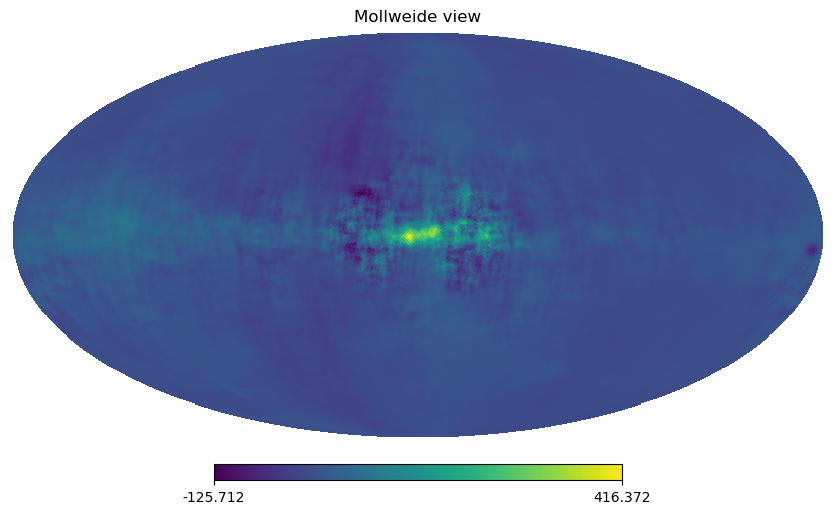

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v2/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'

MAC_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MAC_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MAC_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MAC_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MAC_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MAC_obj.nside, new=True, lmax=MAC_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MAC_obj.number_frequencies).reshape((MAC_obj.number_frequencies,MAC_obj.nstokes,MAC_obj.npix),order='F')
        

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, pos_special_freqs=MAC_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MAC_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MAC_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MAC_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [6]:
s_cML = micmac.get_Wd(MAC_obj.freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=True)[0, :, :]

In [7]:
CMB_c_ell = jnp.zeros((MAC_obj.number_correlations, MAC_obj.lmax+1))
# CMB_c_ell[:,MAC_obj.lmin:] = (theoretical_r0_total + MAC_obj.r_true*theoretical_r1_tensor)
CMB_c_ell = CMB_c_ell.at[:,MAC_obj.lmin:].set(theoretical_r0_total + MAC_obj.r_true*theoretical_r1_tensor)

red_cov_matrix = micmac.get_reduced_matrix_from_c_ell_jax(CMB_c_ell)[MAC_obj.lmin:,...]


In [8]:
lmax = MAC_obj.lmax
n_iter = MAC_obj.n_iter
lmin = MAC_obj.lmin
nstokes = MAC_obj.nstokes

In [9]:
%%time

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
# eta_maps = np.zeros((nstokes, npix))
# map_random_x = []
# map_random_y = []
# eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
# eta_maps = micmac.get_sampling_eta_v2(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, lmin=lmin, n_iter=n_iter)

jax_key_PNRG = jax.random.PRNGKey(MAC_obj.seed+2)
map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
initial_guess = jnp.empty(0)

fluctuation_maps = MAC_obj.get_fluctuating_term_maps(red_cov_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess)

Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!
CPU times: user 6.91 s, sys: 1.48 s, total: 8.39 s
Wall time: 3.17 s


In [10]:
jitted_getting_fluctuation = jax.jit(MAC_obj.get_fluctuating_term_maps)

In [11]:
# %%time
# fluctuation_maps = jitted_getting_fluctuation(red_cov_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess)

In [12]:
# %%time
# fluctuation_maps = jitted_getting_fluctuation(red_cov_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess)

In [13]:
# %%time
# fluctuation_maps = jitted_getting_fluctuation(red_cov_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess)

In [14]:
%%time
initial_guess = jnp.empty(0)

wiener_filter_term = MAC_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess)

CG-Python-0 WF finished in  None iterations !!
CPU times: user 3.61 s, sys: 883 ms, total: 4.49 s
Wall time: 969 ms


In [15]:
jitted_getting_Wiener_filter = jax.jit(MAC_obj.solve_generalized_wiener_filter_term)

In [16]:
# %%time
# wiener_filter_term = jitted_getting_Wiener_filter(s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess)

In [17]:
# %%time
# wiener_filter_term = jitted_getting_Wiener_filter(s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess)

In [18]:
# %%time
# wiener_filter_term = jitted_getting_Wiener_filter(s_cML, red_cov_matrix, BtinvNB, initial_guess=initial_guess)

In [19]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

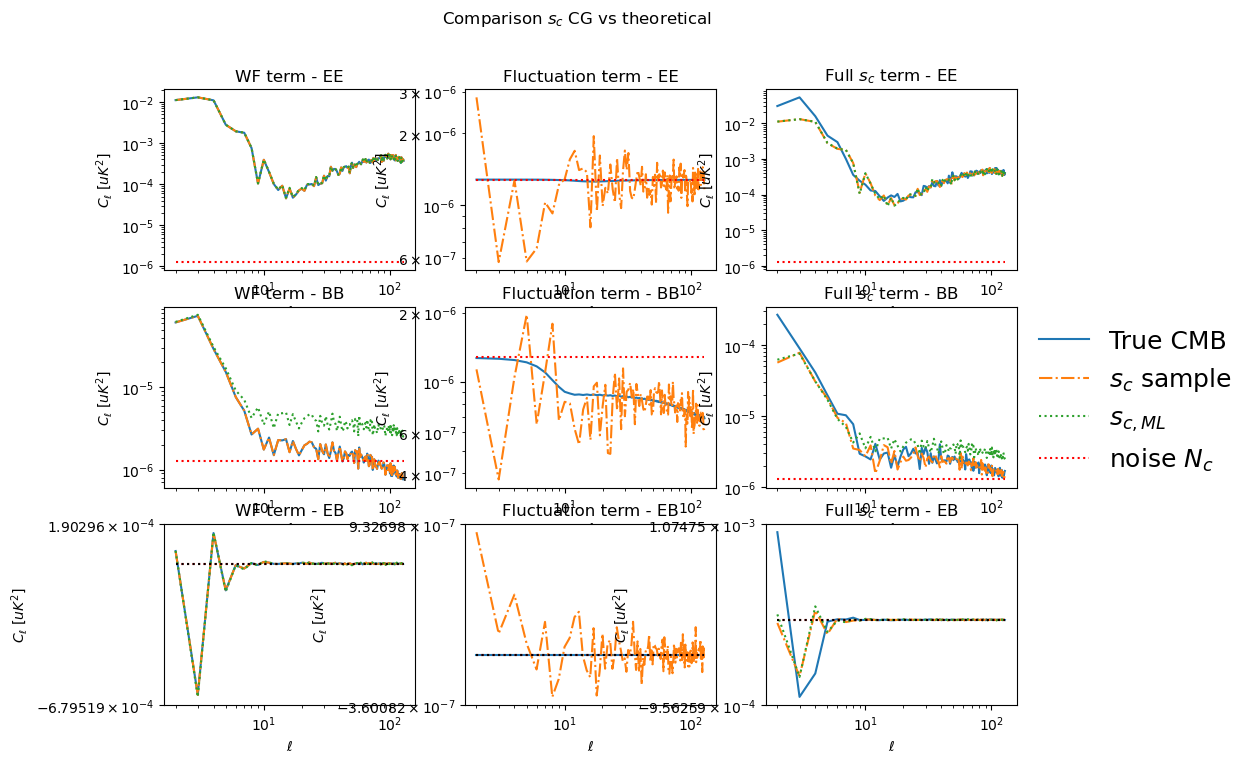

In [22]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MAC_obj.lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

# covariance_noise = np.zeros_like(c_ell_true_CMB)
# covariance_noise[:nstokes,:] = (BtinvNB[0,0]*np.ones_like(c_ell_true_CMB)[:nstokes,:])

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MAC_obj.nside)**2,
                                                                       analytical_WF_harm, lmin=lmin, n_iter=n_iter)



analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_sample = wiener_filter_term + fluctuation_maps

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MAC_obj.lmax, iter=MAC_obj.n_iter)[indices_polar,MAC_obj.lmin:]

plt.figure(figsize=(11,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MAC_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MAC_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    # plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MAC_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    # plt.legend()
    

    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MAC_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MAC_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1, 2.2), loc="upper left", prop={'size': 18}, frameon=False)
    
    
    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")

    plt.xlabel(r"$\ell$")
    # plt.legend()
plt.show()